In [20]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


In [22]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path


In [23]:
ruta_datos  = "Filtrados_por_Canales"

archivos_eventos = list(Path(ruta_datos, 'Eventos').glob("*.csv"))
archivos_no_eventos = list(Path(ruta_datos, 'No_eventos').glob("*.csv"))

print("Archivos en Eventos:", len(archivos_eventos))
print("Archivos en No_eventos:", len(archivos_no_eventos))


Archivos en Eventos: 454
Archivos en No_eventos: 456


In [24]:
columnas_deseadas = ["X5", "X6", "DC3", "X7", "X8", "SaO2"]

df_total = []

for etiqueta, nombre_carpeta in enumerate(['No_eventos', 'Eventos']):  # 0: No_eventos, 1: Eventos
    ruta_carpeta = os.path.join(ruta_datos, nombre_carpeta)
    
    for archivo in os.listdir(ruta_carpeta):
        if archivo.endswith('.csv'):
            ruta_archivo = os.path.join(ruta_carpeta, archivo)
            df = pd.read_csv(ruta_archivo)

            if all(col in df.columns for col in columnas_deseadas):
                # Nos quedamos solo con las columnas deseadas
                df_filtrado = df[columnas_deseadas]

                # Convertimos la señal multicanal a una sola fila
                fila = pd.DataFrame([df_filtrado.values.flatten()])
                fila['etiqueta'] = etiqueta

                df_total.append(fila)

# Concatenamos en un solo DataFrame
df_datos = pd.concat(df_total, ignore_index=True)

# Dividir por clase
df_eventos = df_datos[df_datos['etiqueta'] == 1]
df_no_eventos = df_datos[df_datos['etiqueta'] == 0]

# Balancear
min_len = min(len(df_eventos), len(df_no_eventos))
df_eventos = df_eventos.sample(min_len, random_state=42)
df_no_eventos = df_no_eventos.sample(min_len, random_state=42)

# Unir y mezclar
df_balanceado = pd.concat([df_eventos, df_no_eventos], ignore_index=True).sample(frac=1, random_state=42)

# Separar X e y
X = df_balanceado.drop(columns=['etiqueta']).values
y = df_balanceado['etiqueta'].values

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Imprimir formas
print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)

# Imprimir cantidad por clase
print("\nDistribución de clases:")
print("Entrenamiento - No_eventos:", np.sum(y_train == 0))
print("Entrenamiento - Eventos:", np.sum(y_train == 1))
print("Prueba - No_eventos:", np.sum(y_test == 0))
print("Prueba - Eventos:", np.sum(y_test == 1))


Shape X_train: (635, 2250)
Shape X_test: (273, 2250)

Distribución de clases:
Entrenamiento - No_eventos: 317
Entrenamiento - Eventos: 318
Prueba - No_eventos: 137
Prueba - Eventos: 136


c:\Users\Zamanta\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Zamanta\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Zamanta\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Zamanta\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the opti

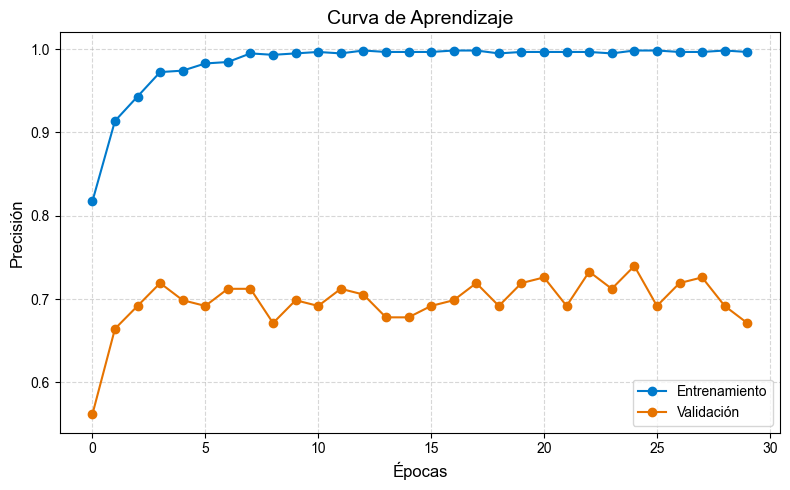

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# ===============
# ESCALADO Y DATOS
# ===============
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División en entrenamiento, validación y prueba
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

# ===============
# ENTRENAMIENTO MANUAL POR ÉPOCAS
# ===============
epochs = 30
train_acc = []
val_acc = []

# Creamos el modelo
model = MLPClassifier(hidden_layer_sizes=(32, 16),activation='relu'
                    ,solver='adam',alpha=0.001
                    ,batch_size=32,learning_rate_init=0.001,
                    max_iter=1, random_state=42)

# Entrenamiento por época manual
for epoch in range(epochs):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    train_acc.append(accuracy_score(y_train, y_train_pred))
    val_acc.append(accuracy_score(y_val, y_val_pred))

# ===============
# GRAFICAR PRECISIÓN POR ÉPOCAS
# ===============
plt.rcParams.update({'font.family': 'Arial'})  # Para mantener estilo

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train_acc, label='Entrenamiento', color='#007acc', marker='o')
ax.plot(val_acc, label='Validación', color='#e67300', marker='o')

ax.set_title('Curva de Aprendizaje', fontsize=14)
ax.set_xlabel('Épocas', fontsize=12)
ax.set_ylabel('Precisión', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()



In [26]:
# Predicciones sobre el set de entrenamiento
y_train_pred = modelo.predict(X_train)

# Métricas detalladas en entrenamiento
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_macro_train = precision_score(y_train, y_train_pred, average='macro')
precision_weighted_train = precision_score(y_train, y_train_pred, average='weighted')
recall_macro_train = recall_score(y_train, y_train_pred, average='macro')
f1_train = f1_score(y_train, y_train_pred, average=None)  # Por clase
f1_macro_train = f1_score(y_train, y_train_pred, average='macro')
f1_weighted_train = f1_score(y_train, y_train_pred, average='weighted')
f1_micro_train = f1_score(y_train, y_train_pred, average='micro')
support_train = confusion_matrix(y_train, y_train).diagonal()  # soporte real por clase

# Imprimir métricas
print("\n--- MÉTRICAS (Entrenamiento) ---")
print(f"Accuracy         : {accuracy_train:.4f}")
print(f"Precision (W)    : {precision_weighted_train:.4f}")
print(f"Recall (Macro)   : {recall_macro_train:.4f}")
print(f"F1-score         : clase 0: {f1_train[0]:.4f} | clase 1: {f1_train[1]:.4f}")
print(f"F1-score (W)     : {f1_weighted_train:.4f}")
print(f"F1-score (Macro) : {f1_macro_train:.4f}")
print(f"F1-score (Micro) : {f1_micro_train:.4f}")
print(f"Support          : No_eventos = {support_train[0]}, Eventos = {support_train[1]}")


NameError: name 'modelo' is not defined

In [ ]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Mostrar matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No_eventos', 'Eventos'], yticklabels=['No_eventos', 'Eventos'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión datos de entrenamiento')
plt.show()